In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import OxfordIIITPet

In [25]:
from torchvision.transforms import v2

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = v2.Compose([
    v2.Resize((256, 256)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean, std),
])

tgt_transform = v2.Compose([
    v2.Resize((256, 256)),
    v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
    v2.Lambda(lambda x: torch.where(x == 1, 0, x)),
    v2.Lambda(lambda x: torch.where(x == 2, 1, x)),
    v2.Lambda(lambda x: torch.where(x == 3, 2, x)),
])


train_val_dataset = OxfordIIITPet(root=".",
                              split="trainval",
                              target_types="segmentation",
                              transform=transform,
                              target_transform=tgt_transform,
                              download=True)
test_dataset = OxfordIIITPet(root=".",
                             split="test",
                             target_types="segmentation",
                             transform=transform,
                             target_transform=tgt_transform,
                             download=True)


train_dataset, val_dataset = random_split(train_val_dataset, [0.9, 0.1])

print(f"Length of train dataset: {len(train_dataset)}")
print(f"Length of val dataset: {len(val_dataset)}")
print(f"Length of test dataset: {len(test_dataset)}")

Length of train dataset: 3312
Length of val dataset: 368
Length of test dataset: 3669


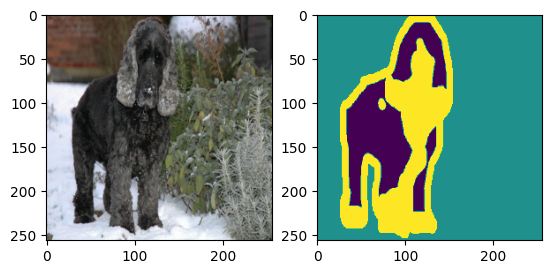

In [30]:
import matplotlib.pyplot as plt

x, y = train_dataset[0]

tensor2img = v2.ToPILImage()
unnormal = v2.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)
x = unnormal(x)
x = tensor2img(x)

y = tensor2img(y)

plt.subplot(1, 2, 1)
plt.imshow(x)
plt.subplot(1, 2, 2)
plt.imshow(y)
plt.show()

In [31]:
batch_size = 32

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [32]:
class DownSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownSampleBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        out = self.pool(x)
        return out , x

class UpConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConvBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.activation = nn.ReLU()

    def forward(self, x, skip_x):
        x = self.up(x)
        x = torch.cat((x, skip_x), dim=1)
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        return x

class UNetModel(nn.Module):
    def __init__(self):
        super(UNetModel, self).__init__()
        # down sample layers
        self.down_sample_block1 = DownSampleBlock(3, 64)
        self.down_sample_block2 = DownSampleBlock(64, 128)
        self.down_sample_block3 = DownSampleBlock(128, 256)
        self.down_sample_block4 = DownSampleBlock(256, 512)

        # bottom
        self.conv1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)

        # upsample
        self.up_sample_block1 = UpConvBlock(1024, 512)
        self.up_sample_block2 = UpConvBlock(512, 256)
        self.up_sample_block3 = UpConvBlock(256, 128)
        self.up_sample_block4 = UpConvBlock(128, 64)

        # output layer
        self.output_layer = nn.Conv2d(64, 3, kernel_size=1)


    def forward(self, x):
        out, block1_out_before_pool = self.down_sample_block1(x)
        out, block2_out_before_pool = self.down_sample_block2(out)
        out, block3_out_before_pool = self.down_sample_block3(out)
        out, block4_out_before_pool = self.down_sample_block4(out)

        out = self.conv1(out)
        out = self.conv2(out)

        out = self.up_sample_block1(out, block4_out_before_pool)
        out = self.up_sample_block2(out, block3_out_before_pool)
        out = self.up_sample_block3(out, block2_out_before_pool)
        out = self.up_sample_block4(out, block1_out_before_pool)
        out = self.output_layer(out)
        return out

x, y = train_dataset[0]
x = x.unsqueeze(0)
model = UNetModel()
out = model(x)
print(out.shape)

loss_fn = nn.CrossEntropyLoss()
out_comp = out
print(y.unique())
y_comp = y.long()
print(y_comp)
print(out_comp.shape, y_comp.shape)
loss = loss_fn(out_comp, y_comp)
print(loss)


torch.Size([1, 3, 256, 256])
tensor([0, 1, 2], dtype=torch.uint8)
tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]])
torch.Size([1, 3, 256, 256]) torch.Size([1, 256, 256])
tensor(1.0763, grad_fn=<NllLoss2DBackward0>)


In [33]:
from tqdm import tqdm

def train(model, train_dl, val_dl, loss_fn, optimizer, epochs, device):
    model = model.to(device)
    loss_train = []
    loss_val = []

    for epoch in range(epochs):
        model.train()
        train_dl_pbar = tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs}")
        loss_tr_sum = 0
        for step, (x, y) in enumerate(train_dl_pbar):
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device).long()
            y = y.squeeze(1)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            loss_tr_sum += loss.item()*x.shape[0]
            train_dl_pbar.set_postfix(loss=loss.item())
        loss_epoch = loss_tr_sum/len(train_dl.dataset)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss_epoch}")
        loss_train.append(loss_epoch)

        model.eval()
        loss_val_sum = 0
        with torch.no_grad():
            for step, (x , y) in enumerate(val_dl):
                x = x.to(device)
                y = y.to(device).long()
                y = y.squeeze(1)

                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                loss_val_sum += loss.item()*x.shape[0]
            loss_epoch_val = loss_val_sum/len(val_dl.dataset)
            loss_val.append(loss_epoch_val)
            print(f"Epoch {epoch+1}/{epochs} - Loss: {loss_epoch_val}")

    return loss_train, loss_val


In [34]:

device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNetModel()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_train, loss_val = train(model, train_dl, val_dl, loss_fn, optimizer, 30, device)

Epoch 1/30: 100%|██████████| 104/104 [01:44<00:00,  1.00s/it, loss=0.877]


Epoch 1/30 - Loss: 0.9553650565769362
Epoch 1/30 - Loss: 0.847467883773472


Epoch 2/30: 100%|██████████| 104/104 [01:43<00:00,  1.01it/s, loss=0.74]


Epoch 2/30 - Loss: 0.7648346190867217
Epoch 2/30 - Loss: 0.7278052983076676


Epoch 3/30: 100%|██████████| 104/104 [01:43<00:00,  1.01it/s, loss=0.782]


Epoch 3/30 - Loss: 0.7062266016927894
Epoch 3/30 - Loss: 0.6801543287608934


Epoch 4/30: 100%|██████████| 104/104 [01:43<00:00,  1.01it/s, loss=0.668]


Epoch 4/30 - Loss: 0.6906820719944682
Epoch 4/30 - Loss: 0.6627341819846112


Epoch 5/30: 100%|██████████| 104/104 [01:43<00:00,  1.01it/s, loss=0.635]


Epoch 5/30 - Loss: 0.6716429930954164
Epoch 5/30 - Loss: 0.8243954466736835


Epoch 6/30: 100%|██████████| 104/104 [01:43<00:00,  1.01it/s, loss=0.624]


Epoch 6/30 - Loss: 0.703029041129034
Epoch 6/30 - Loss: 0.6496244487555131


Epoch 7/30: 100%|██████████| 104/104 [01:43<00:00,  1.00it/s, loss=0.672]


Epoch 7/30 - Loss: 0.6485050666159478
Epoch 7/30 - Loss: 0.6380562238071276


Epoch 8/30: 100%|██████████| 104/104 [01:43<00:00,  1.01it/s, loss=0.598]


Epoch 8/30 - Loss: 0.6134105961103946
Epoch 8/30 - Loss: 0.5654245070789171


Epoch 9/30: 100%|██████████| 104/104 [01:43<00:00,  1.01it/s, loss=0.68]


Epoch 9/30 - Loss: 0.5768680992909676
Epoch 9/30 - Loss: 0.5856206779894622


Epoch 10/30: 100%|██████████| 104/104 [01:43<00:00,  1.01it/s, loss=0.47]


Epoch 10/30 - Loss: 0.5554890887460847
Epoch 10/30 - Loss: 0.5208940531896509


Epoch 11/30: 100%|██████████| 104/104 [01:43<00:00,  1.00it/s, loss=0.432]


Epoch 11/30 - Loss: 0.4943632546830293
Epoch 11/30 - Loss: 0.576655494130176


Epoch 12/30: 100%|██████████| 104/104 [01:43<00:00,  1.01it/s, loss=0.432]


Epoch 12/30 - Loss: 0.4703358840827205
Epoch 12/30 - Loss: 0.4841643520023512


Epoch 13/30: 100%|██████████| 104/104 [01:43<00:00,  1.01it/s, loss=0.472]


Epoch 13/30 - Loss: 0.44066788767271
Epoch 13/30 - Loss: 0.5038134248360343


Epoch 14/30: 100%|██████████| 104/104 [01:43<00:00,  1.00it/s, loss=0.368]


Epoch 14/30 - Loss: 0.4100781382569944
Epoch 14/30 - Loss: 0.3897889813651209


Epoch 15/30: 100%|██████████| 104/104 [01:43<00:00,  1.01it/s, loss=0.358]


Epoch 15/30 - Loss: 0.38469809480911293
Epoch 15/30 - Loss: 0.37354668974876404


Epoch 16/30: 100%|██████████| 104/104 [01:43<00:00,  1.00it/s, loss=0.356]


Epoch 16/30 - Loss: 0.3617875067796108
Epoch 16/30 - Loss: 0.37753615172012994


Epoch 17/30: 100%|██████████| 104/104 [01:43<00:00,  1.01it/s, loss=0.301]


Epoch 17/30 - Loss: 0.34672609777842167
Epoch 17/30 - Loss: 0.37088204596353613


Epoch 18/30: 100%|██████████| 104/104 [01:43<00:00,  1.01it/s, loss=0.318]


Epoch 18/30 - Loss: 0.3572514535148363
Epoch 18/30 - Loss: 0.4229557073634604


Epoch 19/30: 100%|██████████| 104/104 [01:43<00:00,  1.01it/s, loss=0.372]


Epoch 19/30 - Loss: 0.3264415415300839
Epoch 19/30 - Loss: 0.345737865437632


Epoch 20/30: 100%|██████████| 104/104 [01:43<00:00,  1.01it/s, loss=0.356]


Epoch 20/30 - Loss: 0.31834841019289506
Epoch 20/30 - Loss: 0.35661961332611414


Epoch 21/30: 100%|██████████| 104/104 [01:43<00:00,  1.01it/s, loss=0.254]


Epoch 21/30 - Loss: 0.3029834367514808
Epoch 21/30 - Loss: 0.3472913438859193


Epoch 22/30: 100%|██████████| 104/104 [01:43<00:00,  1.01it/s, loss=0.336]


Epoch 22/30 - Loss: 0.3006869802152477
Epoch 22/30 - Loss: 0.3390207070371379


Epoch 23/30: 100%|██████████| 104/104 [01:43<00:00,  1.01it/s, loss=0.248]


Epoch 23/30 - Loss: 0.27629297280657117
Epoch 23/30 - Loss: 0.35863406632257544


Epoch 24/30: 100%|██████████| 104/104 [01:43<00:00,  1.01it/s, loss=0.287]


Epoch 24/30 - Loss: 0.2789318909967579
Epoch 24/30 - Loss: 0.3363914450873499


Epoch 25/30: 100%|██████████| 104/104 [01:43<00:00,  1.01it/s, loss=0.3]


Epoch 25/30 - Loss: 0.26737476690955786
Epoch 25/30 - Loss: 0.40880385429962823


Epoch 26/30: 100%|██████████| 104/104 [01:43<00:00,  1.00it/s, loss=0.3]


Epoch 26/30 - Loss: 0.2571828363886202
Epoch 26/30 - Loss: 0.3451480567455292


Epoch 27/30: 100%|██████████| 104/104 [01:43<00:00,  1.01it/s, loss=0.189]


Epoch 27/30 - Loss: 0.24035621373261806
Epoch 27/30 - Loss: 0.3396021438681561


Epoch 28/30: 100%|██████████| 104/104 [01:43<00:00,  1.00it/s, loss=0.239]


Epoch 28/30 - Loss: 0.2264752897663393
Epoch 28/30 - Loss: 0.37146285953729047


Epoch 29/30: 100%|██████████| 104/104 [01:43<00:00,  1.00it/s, loss=0.223]


Epoch 29/30 - Loss: 0.2301449200525376
Epoch 29/30 - Loss: 0.35208468722260516


Epoch 30/30: 100%|██████████| 104/104 [01:43<00:00,  1.00it/s, loss=0.222]


Epoch 30/30 - Loss: 0.21929673238652916
Epoch 30/30 - Loss: 0.3668426249338233


In [ ]:
plt.plot(loss_train, label="train")
plt.plot(loss_val, label="val")
plt.legend()
plt.show()

In [ ]:
def test(model, test_dl, loss_fn, device):
    model = model.to(device)
    model.eval()
    loss_sum = 0
    with torch.no_grad():
        for step, (x, y) in enumerate(test_dl):
            x = x.to(device)
            y = y.to(device).long()
            y = y.squeeze(1)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss_sum += loss.item()*x.shape[0]
    loss_epoch = loss_sum/len(test_dl.dataset)
    print(f"Test loss: {loss_epoch}")

    return loss_epoch

loss_test = test(model, test_dl, loss_fn, device)


torch.Size([256, 256])
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.uint8)
tensor([0, 1, 2], dtype=torch.uint8)


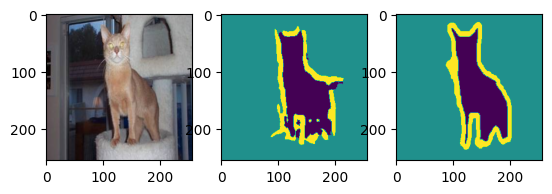

In [37]:
x, y = test_dataset[1]
x = x.unsqueeze(0)
x = x.to(device)
y_pred = model(x)
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.squeeze(0)
y_pred = y_pred.detach().cpu().to(torch.uint8)

print(y_pred.shape)
print(y_pred)
print(y_pred.unique())
tensor2img = v2.ToPILImage()
unnormal = v2.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)
x = unnormal(x)
x = tensor2img(x.squeeze(0))

y_pred = tensor2img(y_pred)
y = tensor2img(y)

plt.subplot(1, 3, 1)
plt.imshow(x)
plt.subplot(1, 3, 2)
plt.imshow(y_pred)
plt.subplot(1, 3, 3)
plt.imshow(y)
plt.show()